**House Prices - Advanced Regression Techniques**

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import StackingRegressor

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

**1. Load data**

In [3]:
def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_csv(file_path).drop('Id', axis=1)


train_data = load_data('./data/train.csv')
test_data = load_data('./data/test.csv')
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

**2. Data Analysis**

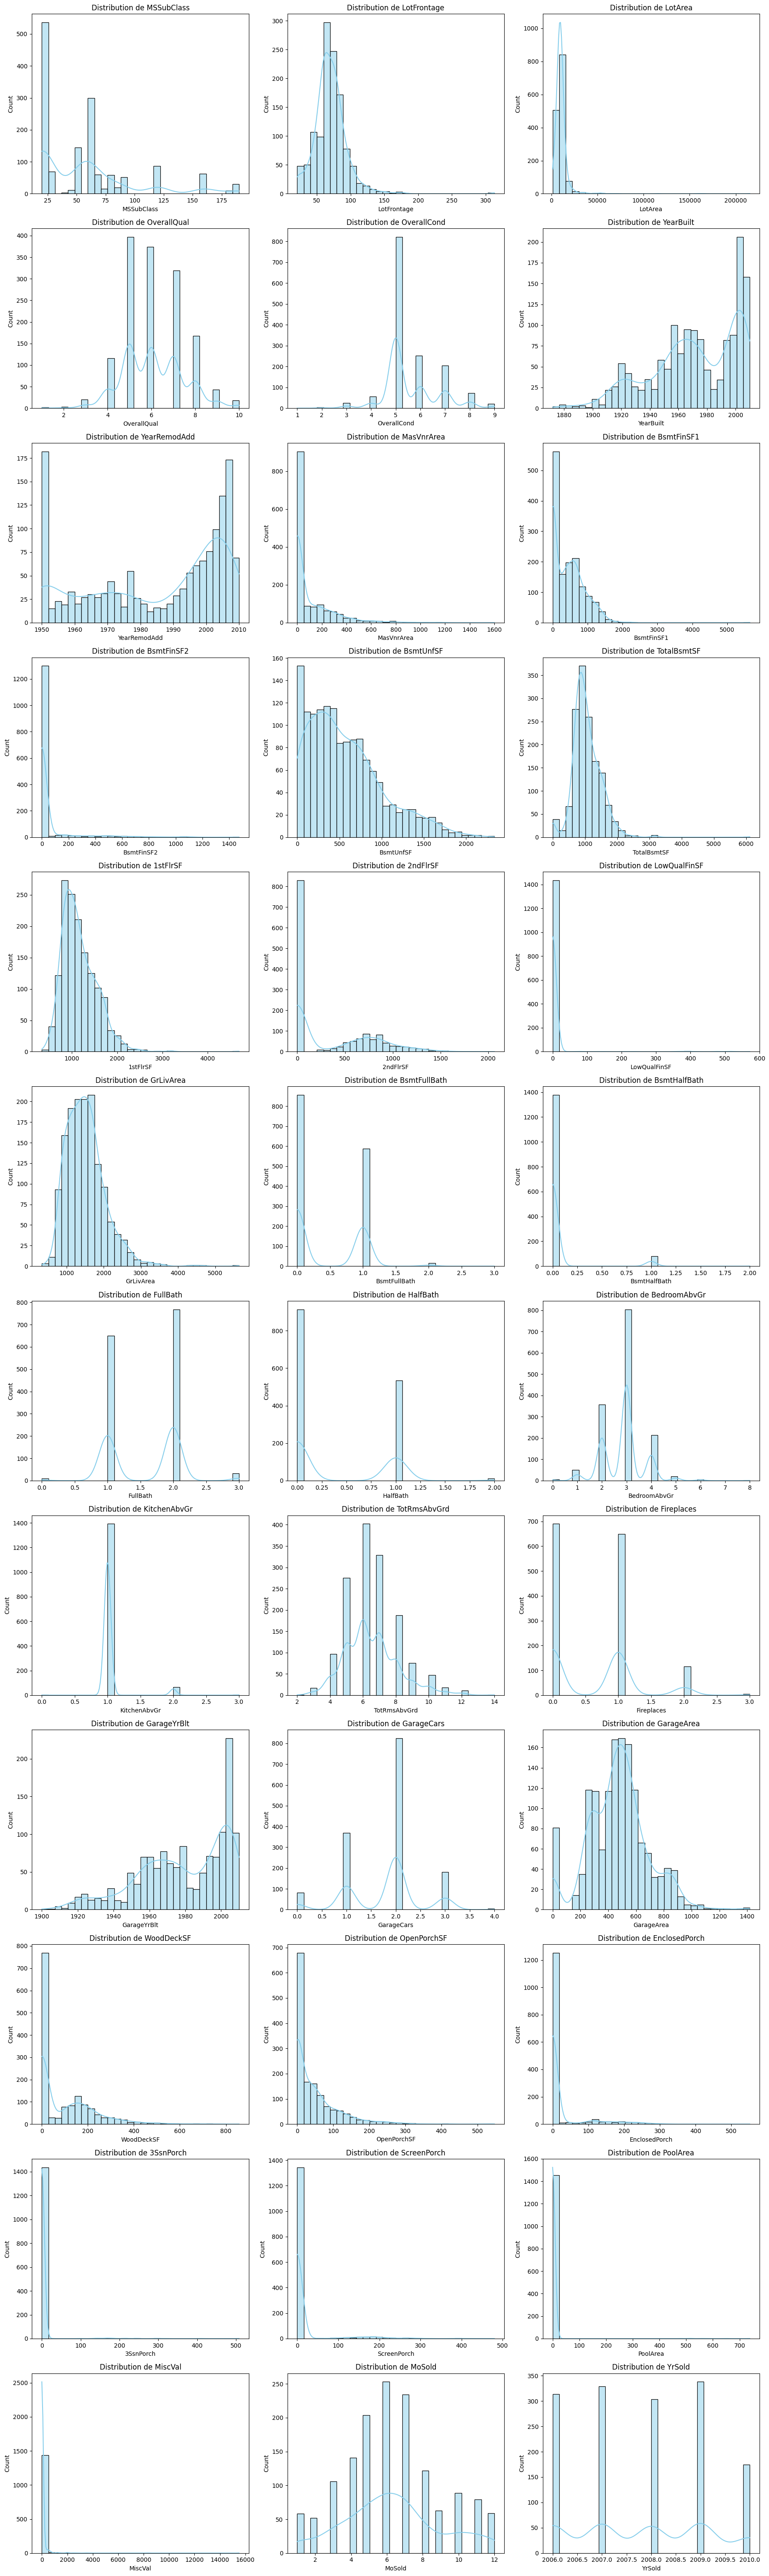

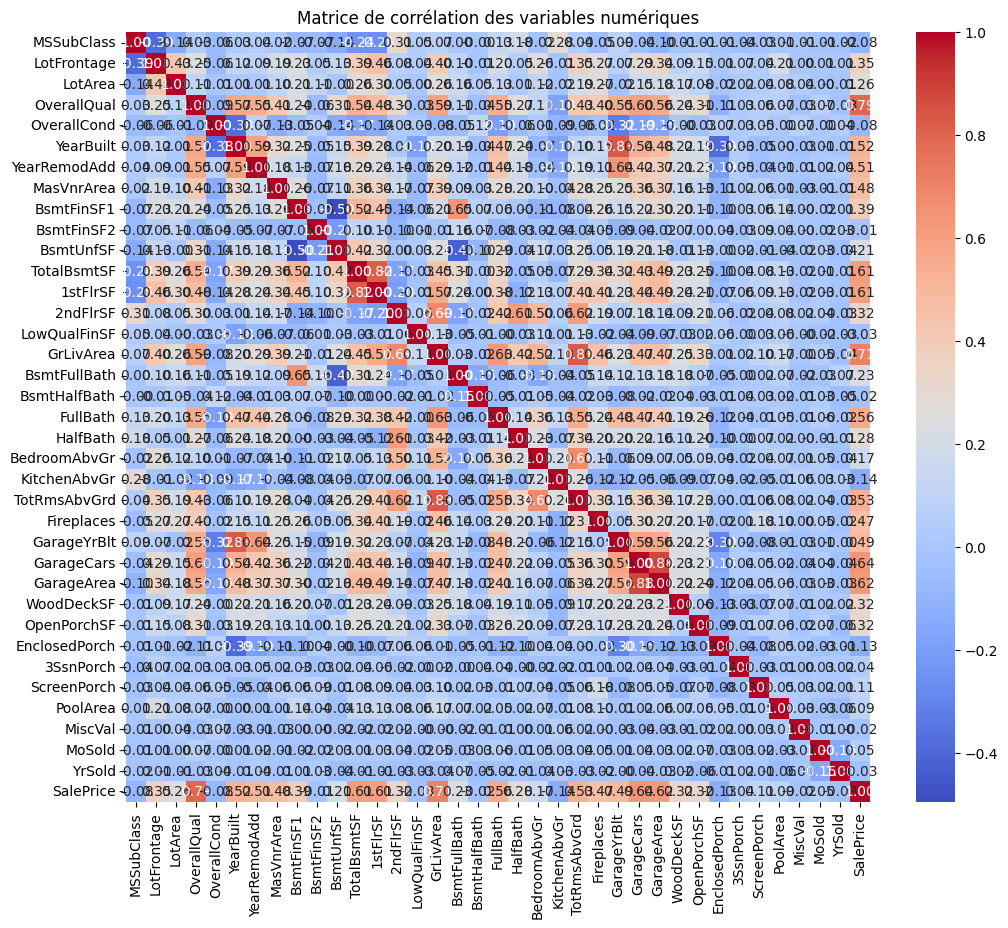

In [4]:
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop('SalePrice')  # on peut exclure la target si on veut

n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(18, 5 * n_rows))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(train_data[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution de {col}')

plt.tight_layout()
plt.show()


# Sélection des colonnes numériques réelles
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

# Calcul de la matrice de corrélation uniquement sur les colonnes numériques
correlation_matrix = train_data[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matrice de corrélation des variables numériques')
plt.show()

**3. Preprocessing of the data**

In [5]:
target = "SalePrice"

# Drop des colonnes non pertinentes
X = train_data.drop(columns=[target, 'YrSold', 'MoSold', 'MiscVal', 'PoolArea', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch'])
y = train_data[target]

# Identifier types
numerical_cols   = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**3. Search and Optimization of the best parameters**

In [6]:
# Hyperparameter grids

param_grid_xgb = {
    'n_estimators': [200, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

param_grid_lgb = {
    'n_estimators': [200, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

param_grid_cat = {
    'iterations': [200, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}


# Modèles
xgb_model = xgb.XGBRegressor(random_state=42, verbosity=0)
lgb_model = lgb.LGBMRegressor(random_state=42)
cat_model = CatBoostRegressor(verbose=0, random_seed=42)

# GridSearchCV avec pipeline
def tune_model(model, param_grid):
    pipeline = Pipeline([
        ('preproc', preprocessor),
        ('model', model)
    ])
    grid = GridSearchCV(
        pipeline, 
        param_grid={'model__' + k: v for k, v in param_grid.items()},
        scoring='neg_mean_absolute_error',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print(f"Best params for {model.__class__.__name__}: {grid.best_params_}")
    return grid.best_estimator_

best_xgb = tune_model(xgb_model, param_grid_xgb)
best_lgb = tune_model(lgb_model, param_grid_lgb)
best_cat = tune_model(cat_model, param_grid_cat)

# Stacking
stack_model = StackingRegressor(
    estimators=[
        ('xgb', best_xgb),
        ('lgb', best_lgb),
        ('cat', best_cat)
    ],
    final_estimator=CatBoostRegressor(iterations=500, verbose=0, random_seed=42),
    n_jobs=-1
)
stack_model.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best params for XGBRegressor: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 500, 'model__subsample': 0.8}
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3126
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 187
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

StackingRegressor(estimators=[('xgb',
                               Pipeline(steps=[('preproc',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('scaler',
                                                                                                  StandardScaler())]),
                                                                                 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',...
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                                               ('model',
                                                <catboost.core.CatBoostRegressor object at 0x00000193FB31BBD0>)]))],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x00000193FAF97310>,
                  n_jobs=-1)

**Evaluation**

In [7]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds) * 100
    print(f"MAE: {mae:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
    return mae, r2, mape

print("\nXGBoost (tuned):")
mae_xgb, r2_xgb, mape_xgb = evaluate_model(best_xgb, X_test, y_test)

print("\nLightGBM (tuned):")
mae_lgb, r2_lgb, mape_lgb = evaluate_model(best_lgb, X_test, y_test)

print("\nCatBoost (tuned):")
mae_cat, r2_cat, mape_cat = evaluate_model(best_cat, X_test, y_test)

print("\nStacking Regressor:")
mae_stack, r2_stack, mape_stack = evaluate_model(stack_model, X_test, y_test)

# Comparaison
results_df = pd.DataFrame([
    ['XGBoost', mae_xgb, r2_xgb, mape_xgb],
    ['LightGBM', mae_lgb, r2_lgb, mape_lgb],
    ['CatBoost', mae_cat, r2_cat, mape_cat],
    ['Stacking', mae_stack, r2_stack, mape_stack]
], columns=['Model', 'MAE', 'R2', 'MAPE']).sort_values('MAE')

print("\nComparaison finale :")
print(results_df)



XGBoost (tuned):
MAE: 14904.20, R²: 0.9246, MAPE: 9.11%

LightGBM (tuned):
MAE: 16352.05, R²: 0.8944, MAPE: 9.79%

CatBoost (tuned):
MAE: 15601.55, R²: 0.9105, MAPE: 9.21%

Stacking Regressor:
MAE: 17756.89, R²: 0.8345, MAPE: 10.16%

Comparaison finale :
      Model           MAE        R2       MAPE
0   XGBoost  14904.202777  0.924595   9.106315
2  CatBoost  15601.545990  0.910538   9.205679
1  LightGBM  16352.048462  0.894426   9.791051
3  Stacking  17756.889276  0.834489  10.155570


**Model Comparaison**

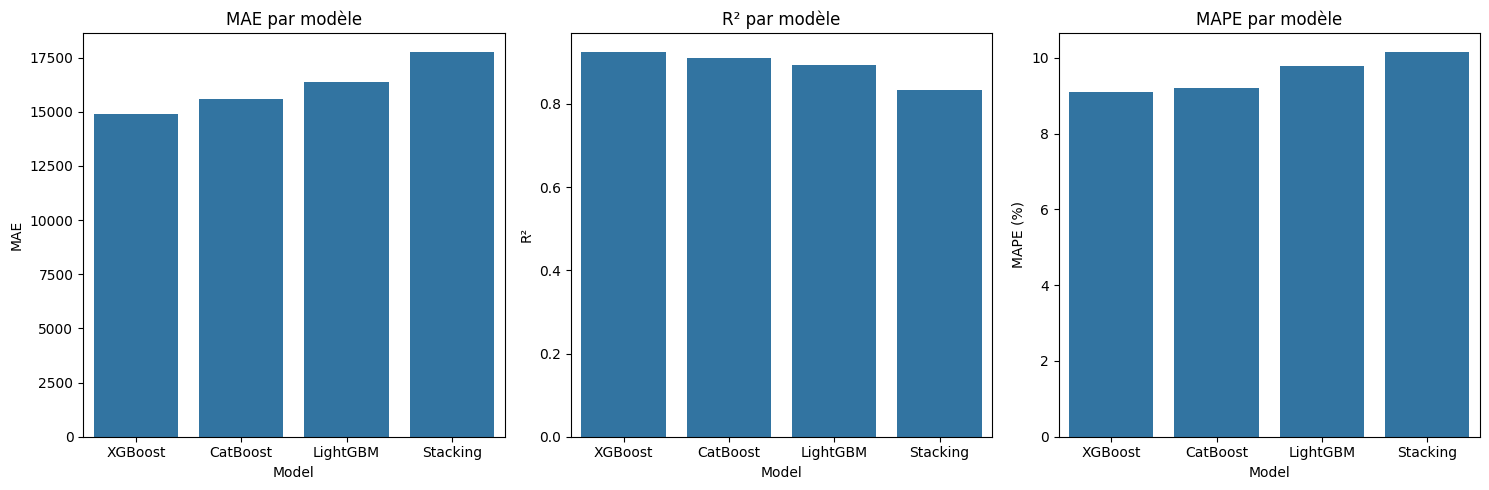

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.barplot(x="Model", y="MAE", data=results_df)
plt.title("MAE par modèle")
plt.ylabel("MAE")

plt.subplot(1,3,2)
sns.barplot(x="Model", y="R2", data=results_df)
plt.title("R² par modèle")
plt.ylabel("R²")

plt.subplot(1,3,3)
sns.barplot(x="Model", y="MAPE", data=results_df)
plt.title("MAPE par modèle")
plt.ylabel("MAPE (%)")

plt.tight_layout()
plt.show()

**Plot feature importance**

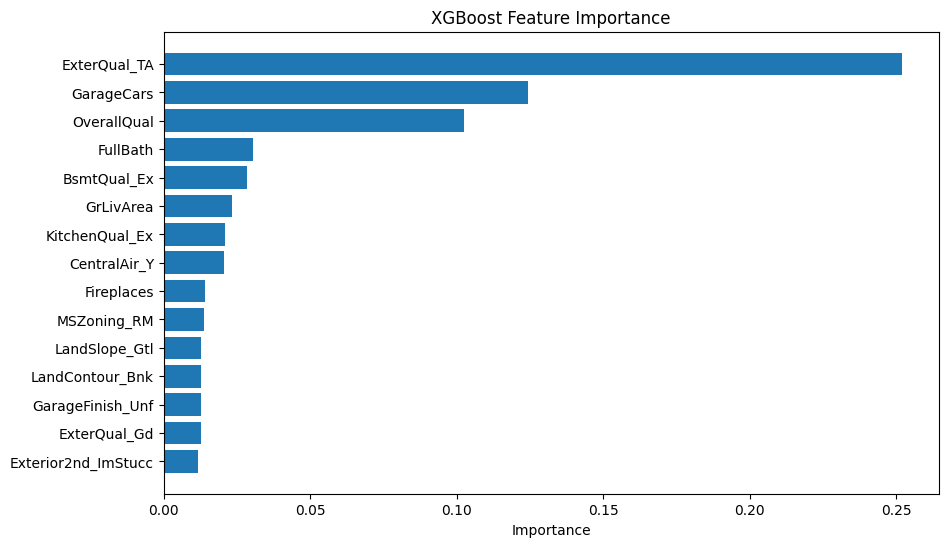

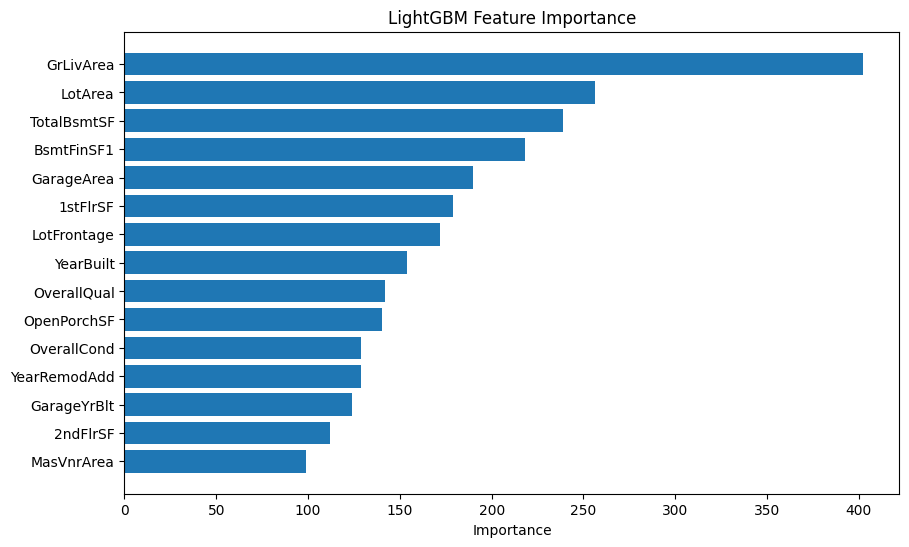

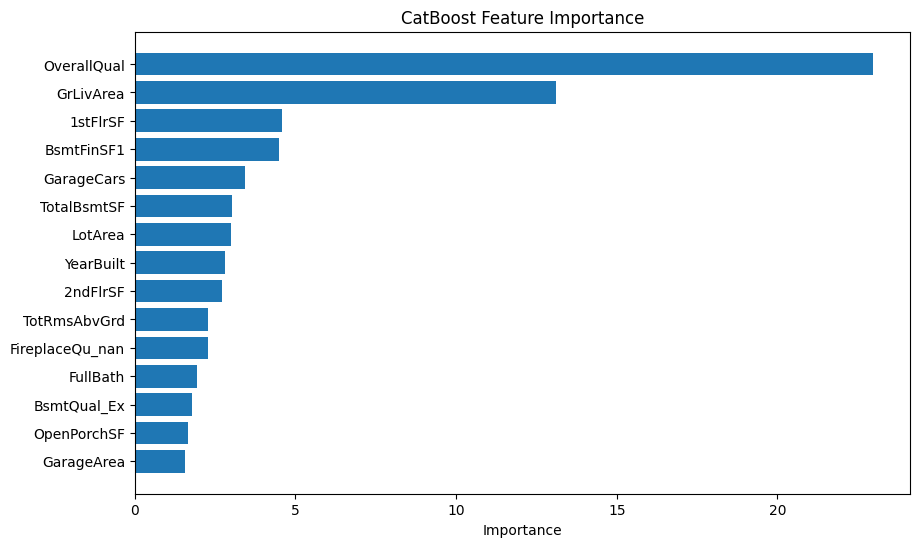

In [9]:
# Fonction pour extraire les noms des features après le préprocessing
def get_feature_names_from_pipeline(pipeline):
    preprocessor = pipeline.named_steps['preproc']
    feature_names = []

    # Colonnes numériques
    feature_names.extend(preprocessor.named_transformers_['num'].feature_names_in_)

    # Colonnes catégorielles
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(preprocessor.transformers_[1][2])
    feature_names.extend(cat_names)

    return feature_names

# Pour chaque modèle
feature_names_xgb = get_feature_names_from_pipeline(best_xgb)
feature_names_lgb = get_feature_names_from_pipeline(best_lgb)
feature_names_cat = get_feature_names_from_pipeline(best_cat)

def plot_feature_importance(model, feature_names, top_n=20, title="Feature Importance"):
    if hasattr(model.named_steps['model'], "feature_importances_"):
        importances = model.named_steps['model'].feature_importances_
    elif hasattr(model.named_steps['model'], "get_feature_importance"):  # CatBoost
        importances = model.named_steps['model'].get_feature_importance()
    else:
        raise ValueError("Model does not have feature importance attribute.")

    indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(10,6))
    plt.barh(range(top_n), importances[indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

# Affichage
plot_feature_importance(best_xgb, feature_names_xgb, top_n=15, title="XGBoost Feature Importance")
plot_feature_importance(best_lgb, feature_names_lgb, top_n=15, title="LightGBM Feature Importance")
plot_feature_importance(best_cat, feature_names_cat, top_n=15, title="CatBoost Feature Importance")